# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [3]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

## Load Data + Use KNN to Impute Missing Values

In [4]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [5]:
# isolate the independent and dependent variables
X_pocket = ANES[['pocketEval']]
X_econ = ANES[['econEval']]
X_ols = ANES[['pocketEval', 'econEval']]

# Quick correlation test between pocketEval and econEval
correlation = ANES[['pocketEval', 'econEval']].corr()
print(correlation) # Low positive correlation indicating they don't measure the same thing


y = ANES['trumpft']

# run the OLS regression for the pocket and econ evaluations
X_ols = sm.add_constant(X_ols)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())

# export the results to a .tex file
with open('outputs/ols_results.tex', 'w') as tf:
    tf.write(model_ols.summary().as_latex())


            pocketEval  econEval
pocketEval    1.000000  0.228858
econEval      0.228858  1.000000
                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     1939.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:59:43   Log-Likelihood:                -39332.
No. Observations:                7998   AIC:                         7.867e+04
Df Residuals:                    7995   BIC:                         7.869e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

## More Complex OLS Regressions (+ Covariates)

In [6]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# run the OLS regression for the simultaneous pocket and econ evaluations with the covariates
regression_cols = ['pocketEval', 'econEval'] + covariates
X_ols_covs = ANES[regression_cols]
X_ols_covs = sm.add_constant(X_ols_covs)
model_ols_covs = sm.OLS(y, X_ols_covs).fit()
print(model_ols_covs.summary())

# export the results to a .tex file
with open('outputs/ols_covs_results.tex', 'w') as tf:
    tf.write(model_ols_covs.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:59:43   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   35.5316 

## Train/Test Split

In [7]:
# define X pocket_cov and X econ_cov
X_pocket_cov = ANES[['pocketEval'] + covariates]
X_econ_cov = ANES[['econEval'] + covariates]

# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train_pocket, y_test_pocket = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train_econ, y_test_econ = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)

# standardize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_pocket_cov_train = scaler.fit_transform(X_pocket_cov_train)
X_pocket_cov_test = scaler.transform(X_pocket_cov_test)
X_econ_cov_train = scaler.fit_transform(X_econ_cov_train)
X_econ_cov_test = scaler.transform(X_econ_cov_test)

# Put back into a pandas dataframe
X_pocket_cov_train = pd.DataFrame(X_pocket_cov_train, columns=X_pocket_cov.columns)
X_pocket_cov_test = pd.DataFrame(X_pocket_cov_test, columns=X_pocket_cov.columns)
X_econ_cov_train = pd.DataFrame(X_econ_cov_train, columns=X_econ_cov.columns)
X_econ_cov_test = pd.DataFrame(X_econ_cov_test, columns=X_econ_cov.columns)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_pocket = scaler_y.fit_transform(y_train_pocket.values.reshape(-1, 1))
y_test_pocket = scaler_y.transform(y_test_pocket.values.reshape(-1, 1))
y_train_econ = scaler_y.fit_transform(y_train_econ.values.reshape(-1, 1))
y_test_econ = scaler_y.transform(y_test_econ.values.reshape(-1, 1))

y_train_pocket = pd.DataFrame(y_train_pocket, columns=['trumpft'])
y_test_pocket = pd.DataFrame(y_test_pocket, columns=['trumpft'])
y_train_econ = pd.DataFrame(y_train_econ, columns=['trumpft'])
y_test_econ = pd.DataFrame(y_test_econ, columns=['trumpft'])
#'''


## LASSO Regression

In [8]:

# fit LASSO models
lasso_pocket = Lasso(alpha=0.05, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train_pocket)

lasso_econ = Lasso(alpha=0.05, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train_econ)

# predict the test set
y_pred_pocket = lasso_pocket.predict(X_pocket_cov_test)
y_pred_econ = lasso_econ.predict(X_econ_cov_test)

# print the intercept, number of nonzero coefficients, and the names of nonzero coefficients
print('Lasso Pocket Model:')
print('Intercept:', lasso_pocket.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_pocket.coef_))
print('Nonzero Coefficients:', X_pocket_cov.columns[lasso_pocket.coef_ != 0].tolist())
print('Accuracy:', r2_score(y_test_pocket, y_pred_pocket))

print('\nLasso Econ Model:')
print('Intercept:', lasso_econ.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_econ.coef_))
print('Nonzero Coefficients:', X_econ_cov.columns[lasso_econ.coef_ != 0].tolist())
print('Accuracy:', r2_score(y_test_econ, y_pred_econ))




Lasso Pocket Model:
Intercept: [-0.02034677]
Number of Nonzero Coefficients: 8
Nonzero Coefficients: ['envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']
Accuracy: 0.8543858395871623

Lasso Econ Model:
Intercept: [-0.02031254]
Number of Nonzero Coefficients: 9
Nonzero Coefficients: ['econEval', 'envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']
Accuracy: 0.8543833698545613


## Neural Network (?)

In [9]:
#
class ANESDataset(Dataset):
    '''Formats the dataset for the neural network'''
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    '''Creates a neural network model with 3 hidden layers'''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train_model, y_train_model, X_test_model, y_test_model, input_dim, hidden_dim, output_dim, n_epochs=50):
    '''Creates and trains a neural network model given the data, the input and output dimensions, and the number of epochs'''
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.001)

    anes_train = ANESDataset(X_train_model, y_train_model)
    anes_test = ANESDataset(X_test_model, y_test_model)

    train_loader = DataLoader(anes_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=64, shuffle=False)


    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader


# Train the pocket eval model
input_dim = X_pocket_cov_train.shape[1]
anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train_pocket, X_pocket_cov_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.365567130446434, Test Loss: 0.10948521822690964
Epoch 2, Train Loss: 0.1876350689679384, Test Loss: 0.08443357437849044
Epoch 3, Train Loss: 0.15473648101091386, Test Loss: 0.08592337310314178
Epoch 4, Train Loss: 0.1303637570142746, Test Loss: 0.08431218639016151
Epoch 5, Train Loss: 0.12476540975272656, Test Loss: 0.08282037541270255
Epoch 6, Train Loss: 0.1256660997867584, Test Loss: 0.08424225047230721
Epoch 7, Train Loss: 0.12050349991768598, Test Loss: 0.08194351598620414
Epoch 8, Train Loss: 0.11843593705445528, Test Loss: 0.08057803317904472
Epoch 9, Train Loss: 0.11690219886600971, Test Loss: 0.08461430877447128
Epoch 10, Train Loss: 0.11667707704007625, Test Loss: 0.08312543407082558
Epoch 11, Train Loss: 0.11861464180052281, Test Loss: 0.0831068816781044
Epoch 12, Train Loss: 0.11496079985052347, Test Loss: 0.0848202620446682
Epoch 13, Train Loss: 0.11193064372986555, Test Loss: 0.08077733919024467
Epoch 14, Train Loss: 0.10934873946011066, Test Loss: 

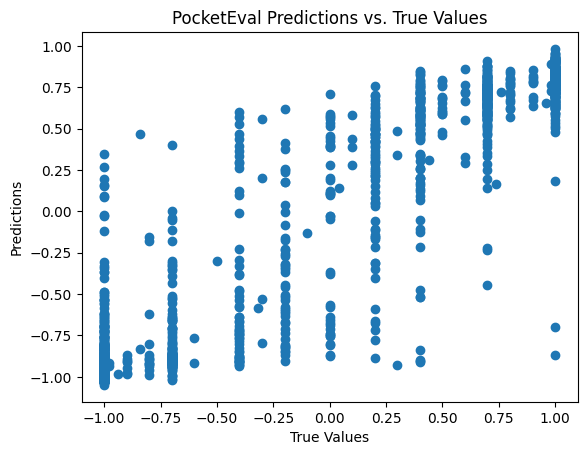

R^2 value for pocketEval model: 0.8786946328973188
MSE for pocketEval model: 0.07900242889943486


In [10]:
# Show the predictions and mean squared error
anes_net_pocket.eval()
pocket_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        pocket_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_pocket, pocket_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('PocketEval Predictions vs. True Values')
plt.show()
y_test_pocket_graph = np.array(y_test_pocket)
pocket_predictions = np.array(pocket_predictions).reshape(-1, 1)
print('R^2 value for pocketEval model:', r2_score(y_test_pocket_graph, pocket_predictions))
print('MSE for pocketEval model:', np.mean((y_test_pocket_graph - pocket_predictions) ** 2))

In [11]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net_econ, anes_loader = train_model(X_econ_cov_train, y_train_econ, X_econ_cov_test, y_test_econ, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.3897840031981468, Test Loss: 0.10335996061563492
Epoch 2, Train Loss: 0.19083584919571878, Test Loss: 0.09485089004039765
Epoch 3, Train Loss: 0.15592350758612156, Test Loss: 0.0905432017147541
Epoch 4, Train Loss: 0.13839820094406605, Test Loss: 0.08936338573694229
Epoch 5, Train Loss: 0.12952393680810928, Test Loss: 0.09113574832677841
Epoch 6, Train Loss: 0.12681578792631626, Test Loss: 0.08539198487997054
Epoch 7, Train Loss: 0.12437275316566229, Test Loss: 0.08496431082487106
Epoch 8, Train Loss: 0.11366548396646976, Test Loss: 0.08604294687509537
Epoch 9, Train Loss: 0.1212587072700262, Test Loss: 0.08568680867552757
Epoch 10, Train Loss: 0.11236358866095543, Test Loss: 0.08278533220291137
Epoch 11, Train Loss: 0.11684176109731198, Test Loss: 0.0832065261900425
Epoch 12, Train Loss: 0.11656054392457009, Test Loss: 0.08394526228308678
Epoch 13, Train Loss: 0.11352220222353936, Test Loss: 0.0810620653629303
Epoch 14, Train Loss: 0.1114137652143836, Test Loss:

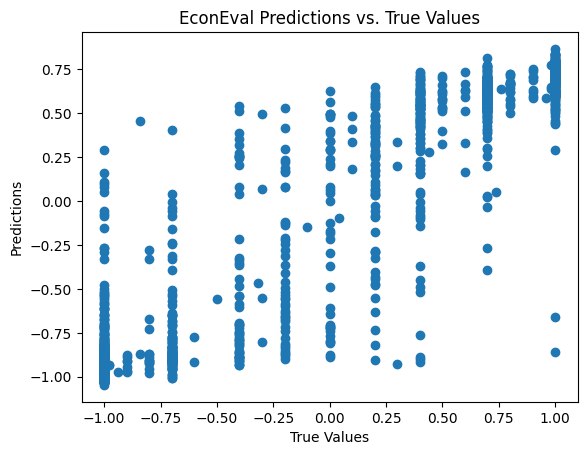

In [12]:
# Show the predictions and mean squared error for the econEval model
anes_net_econ.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_econ(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('EconEval Predictions vs. True Values')
plt.show()

y_test_econ = np.array(y_test_econ)
econ_predictions = np.array(econ_predictions).reshape(-1, 1)


In [13]:
#train a neural network on model without pocketEval and econEval
X_without_train = X_pocket_cov_train.drop(columns=['pocketEval'])
input_dim = X_without_train.shape[1]
X_without_test = X_pocket_cov_test.drop(columns=['pocketEval'])
anes_net_without, anes_loader = train_model(X_without_train, y_train_pocket, X_without_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.38619877979159356, Test Loss: 0.11163308084011078
Epoch 2, Train Loss: 0.19025342844426632, Test Loss: 0.10565396040678024
Epoch 3, Train Loss: 0.14587146632373332, Test Loss: 0.09694989651441574
Epoch 4, Train Loss: 0.1343582982569933, Test Loss: 0.09811221584677696
Epoch 5, Train Loss: 0.12963744297623633, Test Loss: 0.0866790820658207
Epoch 6, Train Loss: 0.12599255941808224, Test Loss: 0.08360747575759887
Epoch 7, Train Loss: 0.12123690389096736, Test Loss: 0.09311162516474723
Epoch 8, Train Loss: 0.11947998095303775, Test Loss: 0.08287010699510575
Epoch 9, Train Loss: 0.11618820250034333, Test Loss: 0.08277491226792336
Epoch 10, Train Loss: 0.1135818000137806, Test Loss: 0.08280903294682503
Epoch 11, Train Loss: 0.1124044068530202, Test Loss: 0.08196404859423638
Epoch 12, Train Loss: 0.11164548233151436, Test Loss: 0.0868941967189312
Epoch 13, Train Loss: 0.10655325904488563, Test Loss: 0.08543578669428825
Epoch 14, Train Loss: 0.11412031035870314, Test Loss

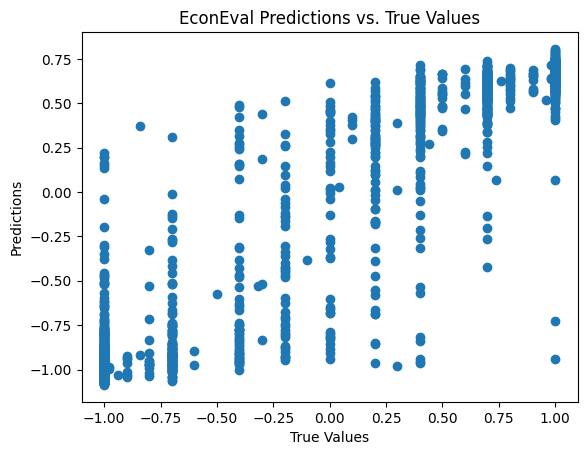

R^2 value for normal model: 0.8649140648171688
MSE for normal model: 0.08797728612091561


In [14]:
# Show the predictions and mean squared error for the model without pocketEval and econEval
anes_net_without.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_without(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('EconEval Predictions vs. True Values')
plt.show()

y_test_graph = np.array(y_test_econ)
econ_predictions = np.array(econ_predictions).reshape(-1, 1)
print('R^2 value for normal model:', r2_score(y_test_graph, econ_predictions))
print('MSE for normal model:', np.mean((y_test_graph - econ_predictions) ** 2))

## Random Forest

R^2 value for pocketEval model: 0.8851968120802028
Mean Squared Error for pocketEval model: 0.07476776096300003


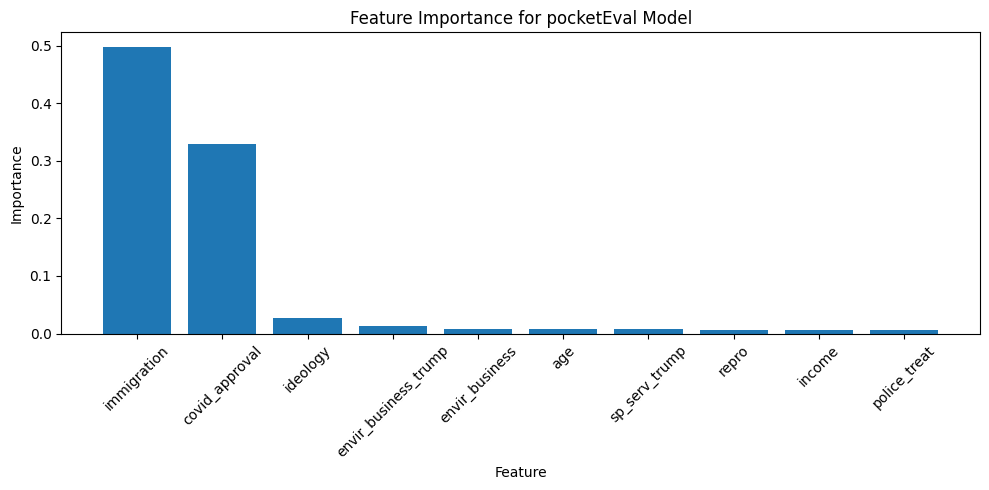

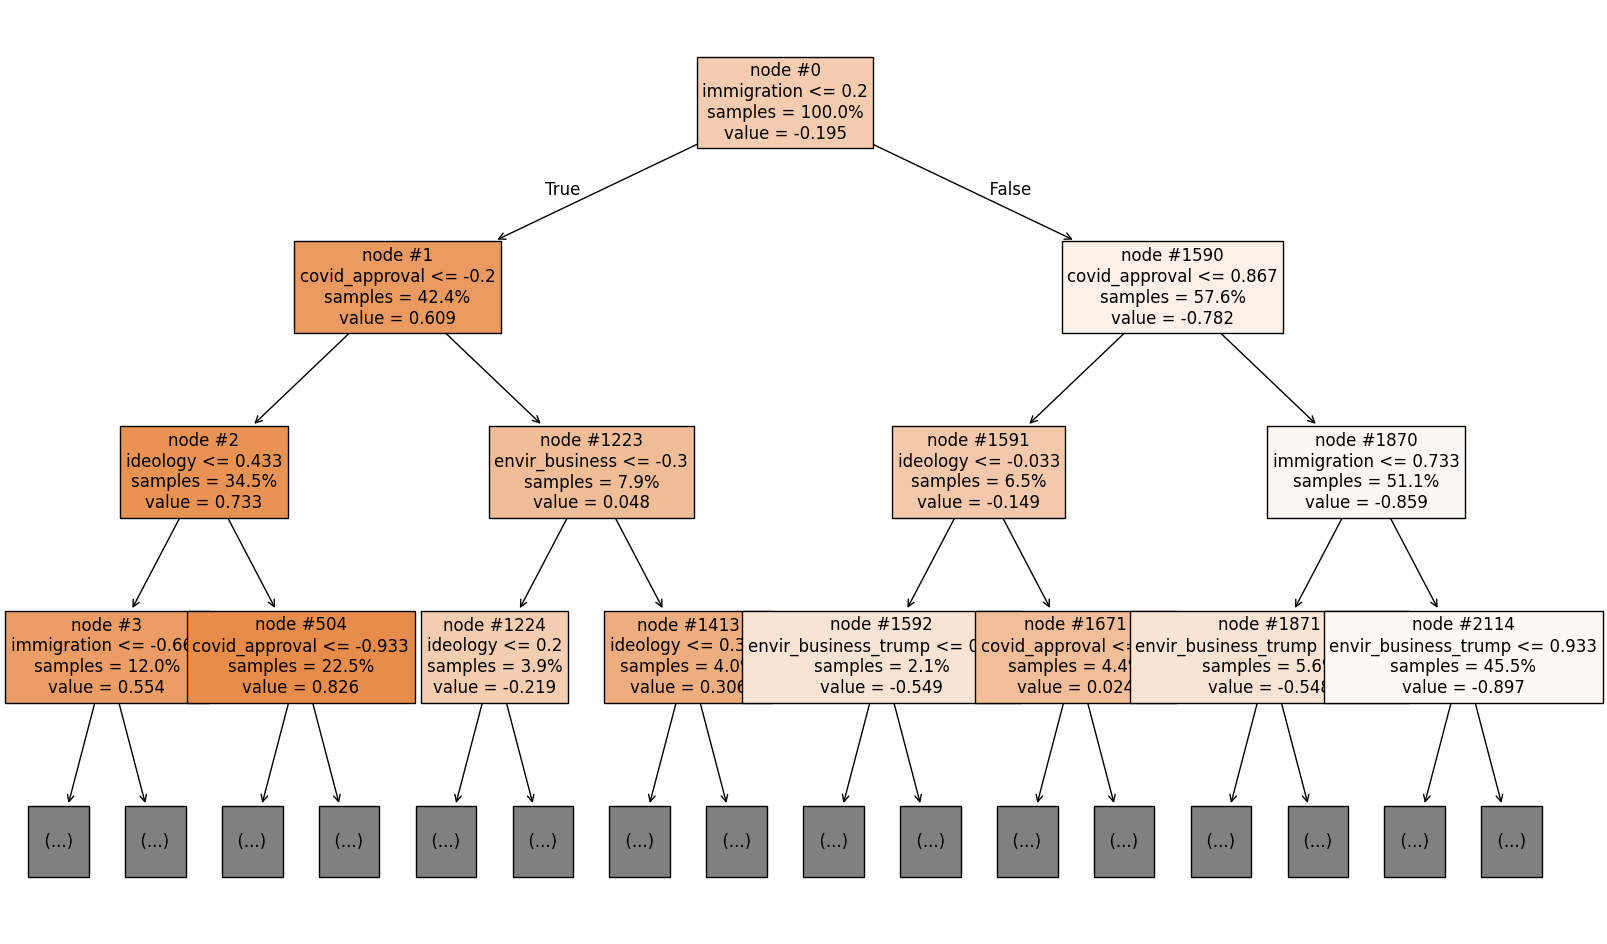

In [15]:
# run a Random Forest on pocketEval test data and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_pocket_1d = y_train_pocket.values.ravel()
rf_pocket.fit(X_pocket_cov_train, y_train_pocket_1d)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
# feature_importance_pocket.head(10)

# print important info for evaluating the pocketEval model
print('R^2 value for pocketEval model:', r2_score(y_test_pocket, rf_pocket.predict(X_pocket_cov_test)))
y_test_pocket_1d = y_test_pocket.values.ravel()
mse_pocket = np.mean((y_test_pocket_1d - rf_pocket.predict(X_pocket_cov_test)) ** 2)
print('Mean Squared Error for pocketEval model:', mse_pocket)

# images of the random forest feature importances for pocketEval
plt.figure(figsize=(10, 5))
plt.bar(feature_importance_pocket['Feature'][:10], feature_importance_pocket['Importance'][:10])
plt.title('Feature Importance for pocketEval Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/pocket_feature_importance.png')

# create a tree based on immigration split
single_tree = rf_pocket.estimators_[0]
feature_names = X_pocket_cov.columns
immigration_index = np.where(feature_names == 'immigration')[0][0] 
tree = single_tree.tree_
split_nodes = np.where(tree.feature == immigration_index)[0]
if len(split_nodes) > 0:
    root_node = split_nodes[0]
    plt.figure(figsize=(20, 12), dpi=100)  # Increase figure size and resolution
    plot_tree(single_tree, feature_names=feature_names, filled=True, impurity=False, 
            proportion=True, node_ids=True, max_depth=3, fontsize=12)  # Increase font size
    plt.savefig('outputs/pocket_tree.png')

In [18]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_econ_1d = y_train_econ.values.ravel()
rf_econ.fit(X_econ_cov_train, y_train_econ_1d)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)


,Feature,Importance
39,immigration,0.498371
19,covid_approval,0.328680
35,ideology,0.026279
11,envir_business_trump,0.012327
9,envir_business,0.008265
28,age,0.008044
5,sp_serv_trump,0.007439
34,income,0.006063
26,stateFIPS,0.005982
22,police_treat,0.005949


R^2 value for econEval model: 0.8853996721513752
Mean Squared Error for econEval model: 1.205320115551624


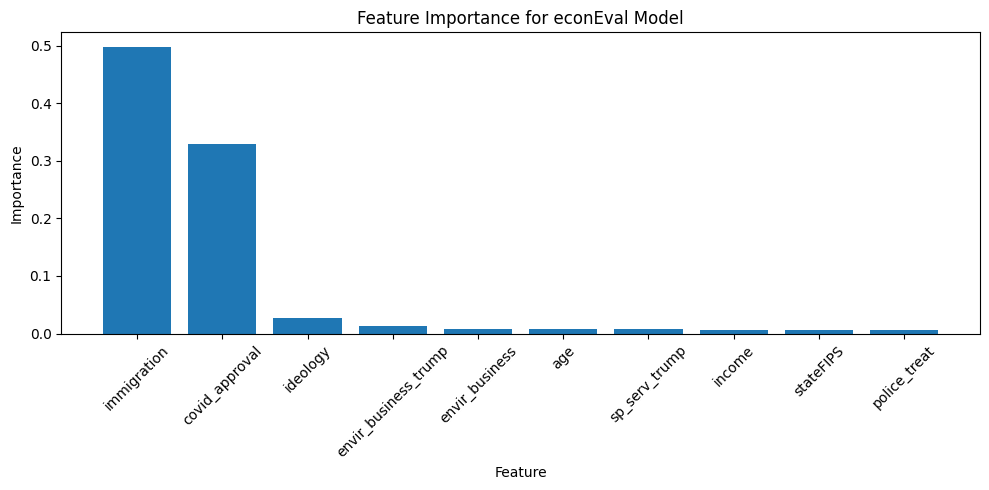

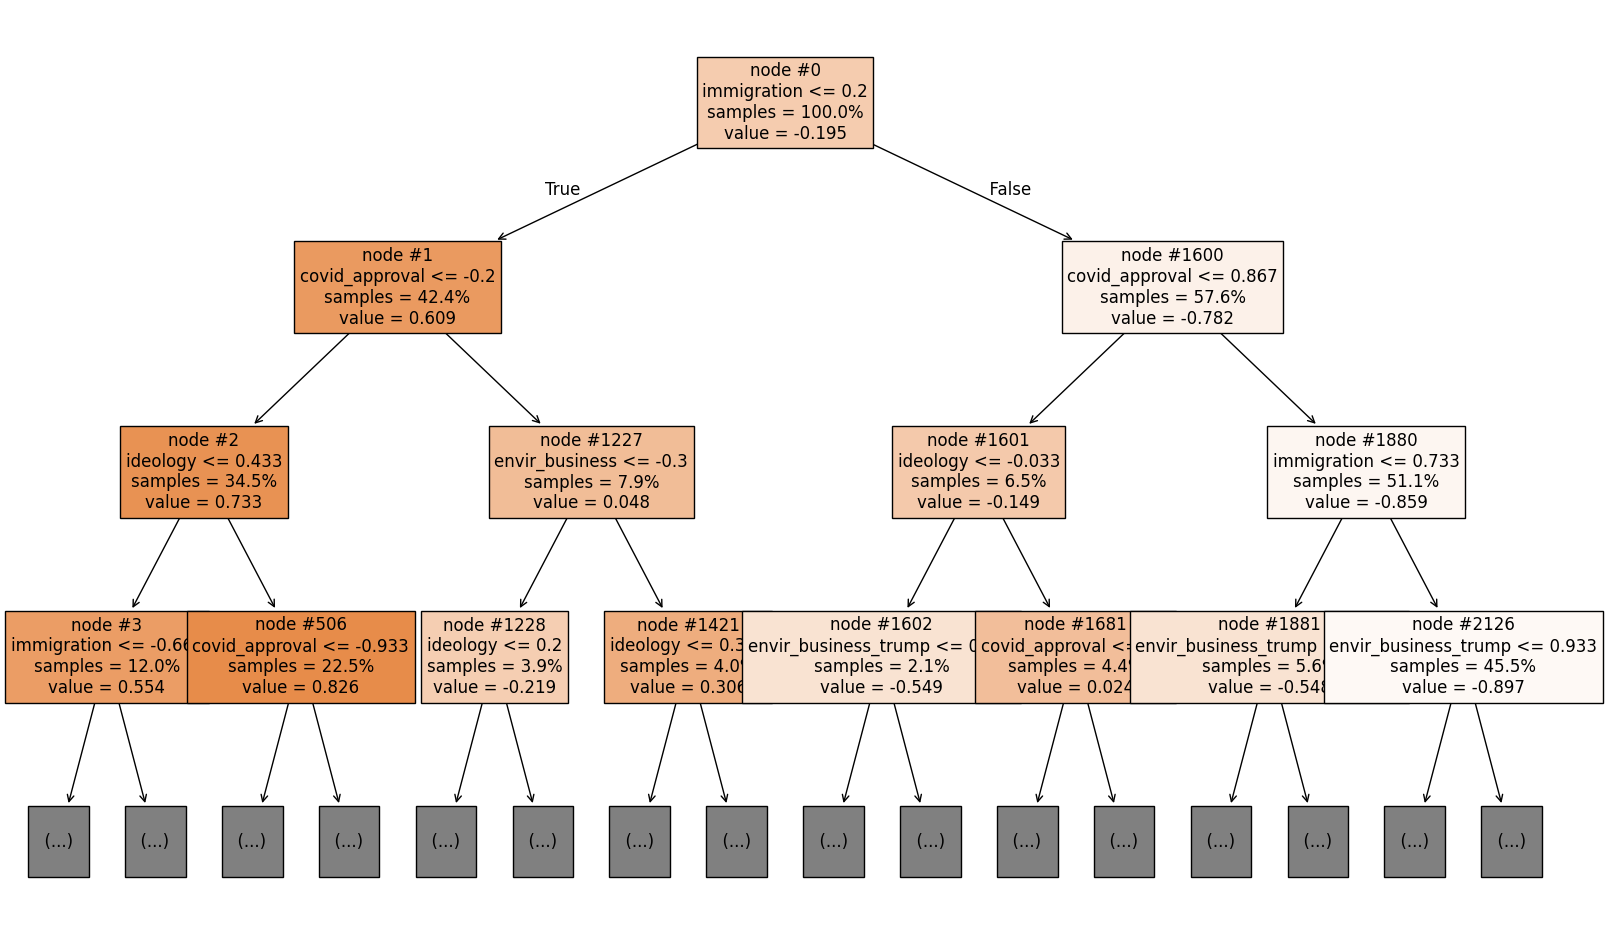

In [20]:
# print important info for evaluating the econEval model
print('R^2 value for econEval model:', r2_score(y_test_econ, rf_econ.predict(X_econ_cov_test)))
y_test_econ_1d = y_test_econ
mse_econ = np.mean((y_test_econ_1d - rf_econ.predict(X_econ_cov_test)) ** 2)
print('Mean Squared Error for econEval model:', mse_econ)

# images of the random forest feature importances for econEval
plt.figure(figsize=(10, 5))
plt.bar(feature_importance_econ['Feature'][:10], feature_importance_econ['Importance'][:10])
plt.title('Feature Importance for econEval Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/econ_feature_importance.png')

# create a tree based on immigration split for econEval
single_tree = rf_econ.estimators_[0]
feature_names = X_econ_cov.columns
immigration_index = np.where(feature_names == 'immigration')[0][0] 
tree = single_tree.tree_
split_nodes = np.where(tree.feature == immigration_index)[0]
if len(split_nodes) > 0:
    root_node = split_nodes[0]
    plt.figure(figsize=(20, 12), dpi=100)  # Increase figure size and resolution
    plot_tree(single_tree, feature_names=feature_names, filled=True, impurity=False, 
            proportion=True, node_ids=True, max_depth=3, fontsize=12)  # Increase font size
    plt.savefig('outputs/econ_tree.png')